In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
pd.options.display.max_rows = 50
pd.options.display.max_rows = 50
pd.options.display.float_format = '{:.2f}'.format
from scipy.optimize import minimize

In [2]:
## just code for ARMA without sector ORGINIAL ONE
pd.options.mode.chained_assignment = None  # default='warn'

def DailyModel(daily_data):

    estimated_daily = {}
    estimated_daily['Daily'] = Model1(daily_data)

    return Model1(daily_data)

def Model1(daily_data):

    output = arma_ale(daily_data)
    return output[0]['log_total_vol_hat'], output[1], output[2]

def arma_ale(daily_data):
    ''' put it all together (make sure the date you want is within the testing set'''
    modified_data = prep_data(daily_data)
    train, test = split_dataset(modified_data, 0.7)
    y_true = train['y_true'].values
    res = minimize(my_objective, np.array([0.5, 0.5], dtype=float), y_true)
    phi, theta = res.x
    test['y_hat'] = estimate_y(test['y_true'].values, phi, theta)
    test['log_total_vol_hat'] = test['y_hat'] + test['log_20days_AM']
    return test, phi, theta

# be sure to prepare the dataset for later calculation easily
def prep_data(daily_data):
    '''
    Dataset preparation
    Input:
        csv_file (csv str) : your stock dataset
        stock (str) : your chosen stock capitalized symbol
    Output:
         dataset
    '''
    daily_data['log_20days_AM'] = (np.log(daily_data['total_vol_m'])).shift().rolling(20).mean()
    daily_data['y_true'] = np.log(daily_data['total_vol_m']) - daily_data['log_20days_AM']
    data = daily_data[20:]
    data['log_total_vol_m'] = np.log(data['total_vol_m'])
    #data.set_index('DATE', inplace=True)

    return data
    
def split_dataset(dataset, split_level):
    '''Split dataset into training set and testing set.'''
    n = int(len(dataset) * split_level)
    train = dataset[:n]
    test = dataset[n:]
    train.loc[:,'y_hat'] = estimate_y(train['y_true'].values, 0.7, -0.3)
    return train, test

# find y_hat given y_true
# with unknown eps, phi, theta, we need to calculate them recursively
# here assume the initial eps, which represents the error is zero
def estimate_y(y_true, phi, theta):
    '''
    Calculate y_hat based on known y_true
    Input:
        y_true (array): log(Vt) - 20-day moving average
        phi(float): universal standard is about 0.7
        theta(float): universal standard is about -0.3
    Outputs:
        y_hat (array):estimated y_true
    '''
    n = len(y_true)
    y_hat = np.zeros(n)
    eps = np.zeros(n)
    for t in range(1, n):
        y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1] #where to add additional features
        eps[t] = y_true[t] - y_hat[t]
    return y_hat

def my_objective(param, y_true):
    '''
    Objective loss function for minimizing
    Find the Weighted Asymmetrical Logarithmic Error
    Input:
        param(float array): potential phi and theta
        y_true (array): log(Vt) - 20-day moving average
    Outputs:
        ALE, weighted asymmetrical logarithmic error
    '''
    phi = param[0]
    theta = param[1]
    y_hat = estimate_y(y_true, phi, theta)
    y_diff = y_hat - y_true
    #ALE = np.sum((1.5 + 0.5 * np.sign(y_diff)) * np.abs(y_diff))
    L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
    return L1_v

In [353]:
def get_overnight_gap(daily_data):
    '''Calculate the overnight price gap for prediction date.'''
    daily_data['20d_sd'] = daily_data['CPrc'].rolling(20).std() #our definition of price volatility
    
    daily_data['price_diff'] = daily_data['OPrc'] - daily_data['CPrc'].shift() 

    daily_data['abs_price_diff'] = np.abs(daily_data['price_diff'])

    # signed overnight price gap
    daily_data['overnight_gap_0'] = daily_data['price_diff']/(daily_data['CPrc'].shift(periods=1))
    
    daily_data['overnight_gap_1'] = daily_data['abs_price_diff']/(daily_data['CPrc'].shift(periods=1))

    # 20 days sd only
    daily_data['overnight_gap_2'] = daily_data['price_diff']/daily_data['20d_sd']
    
    daily_data['overnight_gap_3'] = daily_data['abs_price_diff']/daily_data['20d_sd'] 
    
    # 20 days normalized 
    daily_data['overnight_gap_4'] = daily_data['price_diff']/(daily_data['20d_sd'] * daily_data['CPrc'].shift(periods=1))
    
    daily_data['overnight_gap_5'] = daily_data['abs_price_diff']/(daily_data['20d_sd'] * daily_data['CPrc'].shift(periods=1))

    return daily_data

## Pipeline: <br>
#### Step1: Line graph, 5 - 10 stocks -  PICK THE BEST ONE FUNCTION for overnight price gap <br>
#### Step2: Residual Plots <br> 
- Determine the threshold
- Getting the biggest top 10%

In [424]:
plt.rcParams['figure.figsize'] = (25, 8)
plt.rcParams['font.size'] = 14

In [354]:
sp = pd.read_csv("rhupna2taemg8rjb.csv")
sp['log_vol'] = np.log(sp.total_vol_m)
sp['DATE']= pd.to_datetime(sp.DATE)
sp['log_vol'] = np.log(sp.total_vol_m)
tickers = sp.symbol.unique()
days = sp.DATE.unique()
gr_sp = sp.groupby('symbol')
df = gr_sp.apply(get_overnight_gap)  
df = df[~df.isnull().any(axis=1)]

In [363]:
df

,DATE,SYM_ROOT,symbol,CPrc,OPrc,total_vol_m,log_vol,20d_sd,price_diff,abs_price_diff,overnight_gap_0,overnight_gap_1,overnight_gap_2,overnight_gap_3,overnight_gap_4,overnight_gap_5
11902,2018-01-31,A,A,73.43,73.77,1878254.00,14.45,1.75,0.78,0.78,0.01,0.01,0.45,0.45,0.01,0.01
11903,2018-01-31,AAL,AAL,54.32,53.08,5816399.00,15.58,2.61,0.49,0.49,0.01,0.01,0.19,0.19,0.00,0.00
11904,2018-01-31,AAP,AAP,116.99,119.86,1210368.00,14.01,4.56,0.59,0.59,0.00,0.00,0.13,0.13,0.00,0.00
11905,2018-01-31,AAPL,AAPL,167.43,167.00,30125434.00,17.22,3.68,0.03,0.03,0.00,0.00,0.01,0.01,0.00,0.00
11906,2018-01-31,ABBV,ABBV,112.22,116.26,14676099.00,16.50,7.33,0.38,0.38,0.00,0.00,0.05,0.05,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650051,2022-01-03,ZBRA,ZBRA,583.90,592.08,267661.00,12.50,11.25,-3.12,3.12,-0.01,0.01,-0.28,0.28,-0.00,0.00
650052,2022-01-03,ZION,ZION,64.24,63.88,1199692.00,14.00,1.19,0.72,0.72,0.01,0.01,0.60,0.60,0.01,0.01
650053,2022-01-03,ZION,ZIONL,27.12,27.14,1360.00,7.22,0.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
650054,2022-01-03,ZION,ZIONO,26.53,26.64,9251.00,9.13,0.14,0.08,0.08,0.00,0.00,0.56,0.56,0.02,0.02


In [476]:
def model_try_results(data, ticker, formula_1=True):
    stock = data.loc[data.symbol == ticker].reset_index(drop=True)#.set_index('DATE')
    one = DailyModel(stock)[0]
    two = stock.log_vol
    term = 'overnight_gap_0'
    name = 'Price_Gap_Model_0'
    three = stock.overnight_gap_0
    attempt = pd.concat([one, two,three], axis=1).reset_index(drop=True)
    attempt['res'] = attempt.log_vol - attempt.log_total_vol_hat
    #residual = []
    for i in range(1, 7):
        if formula_1:
            result = smf.ols(formula = "res ~ overnight_gap_"+str(i-1),data = attempt).fit()
            attempt[name] = result.params[0] + attempt.log_total_vol_hat + result.params[1]*attempt[term]
        else: #formula 2
            result = smf.ols(formula = "log_vol ~ log_total_vol_hat + overnight_gap_"+str(i-1),data = attempt).fit()
            attempt[name] = result.params[0] + attempt.log_total_vol_hat * result.params[1] + attempt[term] * result.params[2]

        #residual.append(np.sum(attempt.log_vol)-np.sum(attempt[name]))

        if i == 6: 
            break
        term = 'overnight_gap_'+str(i)
        name = 'Price_Gap_Model_'+str(i)
        new = stock[term]
        attempt = pd.concat([attempt, new], axis=1).reset_index(drop=True)
        
    return attempt[~attempt.isnull().any(axis=1)] #,residual

In [311]:
'''
def weighted_model(data, ticker):
    stock = data.loc[data.symbol == ticker].reset_index(drop=True)#.set_index('DATE')
    one = DailyModel(stock)[0]
    two = stock.log_vol
    three = stock.overnight_gap
    attempt = pd.concat([one, two,three], axis=1).reset_index(drop=True)
    #attempt = attempt[~attempt['log_total_vol_hat'].isna()]
    attempt['res'] = attempt.log_vol - attempt.log_total_vol_hat
    result = smf.ols(formula = "res ~ overnight_gap",data = attempt).fit()
    attempt['Price_Gap_Model'] = None
    attempt.loc[attempt.overnight_gap >0, 'Price_Gap_Model'] = attempt.log_total_vol_hat \
                            + attempt.overnight_gap.apply(lambda x: -2.5 * result.params[1] * x if x > 0.5 else -1.5 * result.params[1] * x)

    attempt.loc[attempt.overnight_gap <=0, 'Price_Gap_Model'] = attempt.log_total_vol_hat \
                            + attempt.overnight_gap.apply(lambda x: 2 * result.params[1] * x if x < -0.5 else 1 * result.params[1] * x)
    return attempt[~attempt['Price_Gap_Model'].isna()]
'''

In [498]:
label_lst = ['diff/close price-ex','abs(diff)/close price-ex', 'diff/rolling 20 std', 'abs(diff)/rolling 20 std', 'diff/rolling 20 std * close_px', 'abs(diff)/rolling 20 std * close_px']
term = ['Price_Gap_Model_0', 'Price_Gap_Model_1', 'Price_Gap_Model_2', 'Price_Gap_Model_3', 'Price_Gap_Model_4','Price_Gap_Model_5']
cmap = plt.get_cmap('Paired')
colors = [cmap(i) for i in np.linspace(0, 1, 8)]
def plot_spec_days(data,n,ticker, formula_1):
    data = model_try_results(data,ticker,formula_1)
    for i in range(6):
        plt.plot(data[term[i]][0:n], color = colors[i], label = label_lst[i])
    plt.plot(data.log_total_vol_hat[0:n],color = colors[6],label = 'Baseline Model')
    plt.plot(data.log_vol[0:n], color = colors[7], label = 'Actual Volume')
    plt.legend(label_lst + ['Baseline Model', 'Actual Volume'])
    if formula_1:
        plt.title("Y(residual) ~ < overnight_gap > model on " + ticker)
    else:
        plt.title("Y(log_vol) ~ < predicted_log_vol + overnight_gap > model on " + ticker)

    plt.xlabel(str(n) + " Testing Days")
    plt.ylabel("Total Volume")
    plt.grid(color='gray', linestyle= 'dotted')
    plt.show()

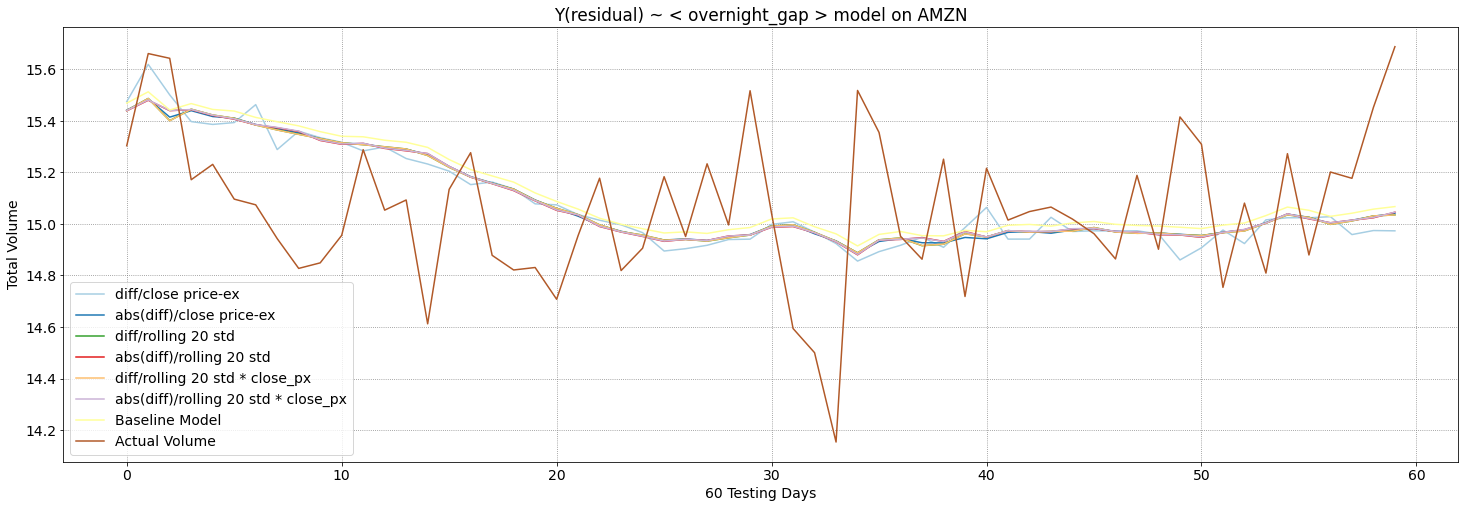

In [519]:
plot_spec_days(df,60, 'AMZN', True)

## EDA Result Observations: <br>
##### abs(diff)/close price-ex : MRNA <br>
##### diff/close price-ex : TSLA, Boeing(BA), bankofamerica(BAC), AMZN, DLTR

In [572]:
def plot_spec_formula(data,n,ticker):
    '''plot overnight price metric with best performance and compare the formula'''
    stock = data.loc[data.symbol == ticker].reset_index(drop=True)#.set_index('DATE')
    one = DailyModel(stock)[0]
    two = stock.log_vol
    term = 'overnight_gap_0'
    name = 'Price_Gap_Model_0'
    three = stock.overnight_gap_0
    attempt = pd.concat([one, two,three], axis=1).reset_index(drop=True)
    attempt['res'] = attempt.log_vol - attempt.log_total_vol_hat
    attempt2 = attempt.copy()

    #formula 1
    result = smf.ols(formula = "res ~ overnight_gap_0",data = attempt).fit()
    attempt[name] = result.params[0] + attempt.log_total_vol_hat + result.params[1]*attempt[term]
    #formula 2
    result_2= smf.ols(formula = "log_vol ~ log_total_vol_hat + overnight_gap_0", data = attempt2).fit()
    attempt2[name] = result_2.params[0] + attempt2.log_total_vol_hat * result_2.params[1] + attempt2[term] * result_2.params[2]

    plt.plot(attempt.log_total_vol_hat[0:n],color = 'black',label = 'Baseline Model', linestyle= 'dotted')
    plt.plot(attempt.log_vol[0:n], color = 'orange', label = 'Actual Volume', linestyle= 'dotted')
    plt.plot(attempt.Price_Gap_Model_0[0:n], color = 'blue', label = 'res ~ overnight_gap_0',linestyle= 'dashed')
    plt.plot(attempt.Price_Gap_Model_0[0:n], color = 'red', label = 'log_vol ~ log_total_vol_hat + overnight_gap_0', linestyle= 'dashdot')
    plt.xlabel(str(n) + " Testing Days")
    plt.ylabel("Total Volume")
    plt.grid(color='gray', linestyle= 'dotted')
    plt.legend(['Baseline Model', 'Actual Volume', 'res ~ overnight_gap_0','log_vol ~ log_total_vol_hat + overnight_gap_0'])

    
    plt.show()


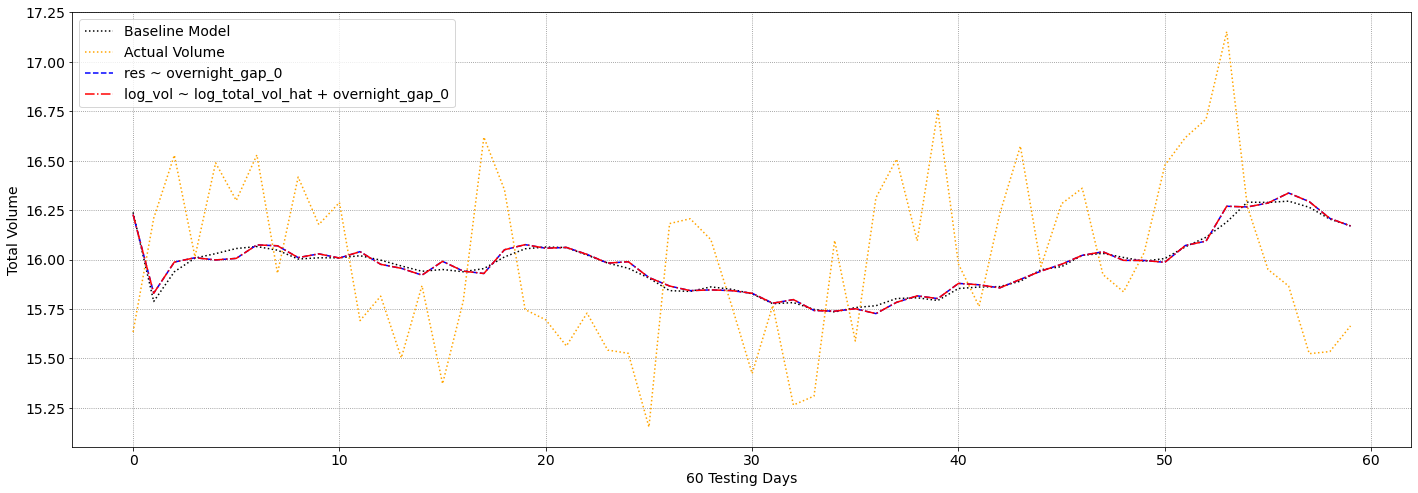

In [573]:
plot_spec_formula(df,60,'MRNA')

In [547]:
plt.rcParams['figure.figsize'] = (24, 8)
plt.rcParams['font.size'] = 14

In [534]:
def scatter_gap_normalized(data, ticker, threshold):
    stock= data.loc[data.symbol == ticker]
    part_one = stock[abs(stock.overnight_gap_0) > threshold]
    part_two = stock[abs(stock.overnight_gap_0) <= threshold]
    plt.xlabel('Price Gap')
    plt.ylabel('Residual Log Volume')
    plt.title("Overnight (Normalized) Price Gap versus Residual Daily Volume - " + ticker)
    plt.scatter(part_two.overnight_gap_0,part_two.log_vol - part_two.log_vol.rolling(20).mean())
    plt.scatter(part_one.overnight_gap_0,part_one.log_vol - part_one.log_vol.rolling(20).mean(), c='r')
    #plt.savefig('Normalized_' + ticker + '_PG_ETA.png', dpi=300)
    plt.show()

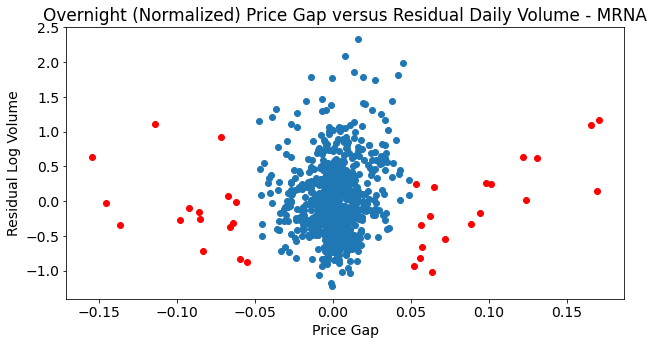

In [543]:
scatter_gap_normalized(df,'MRNA', 0.05)

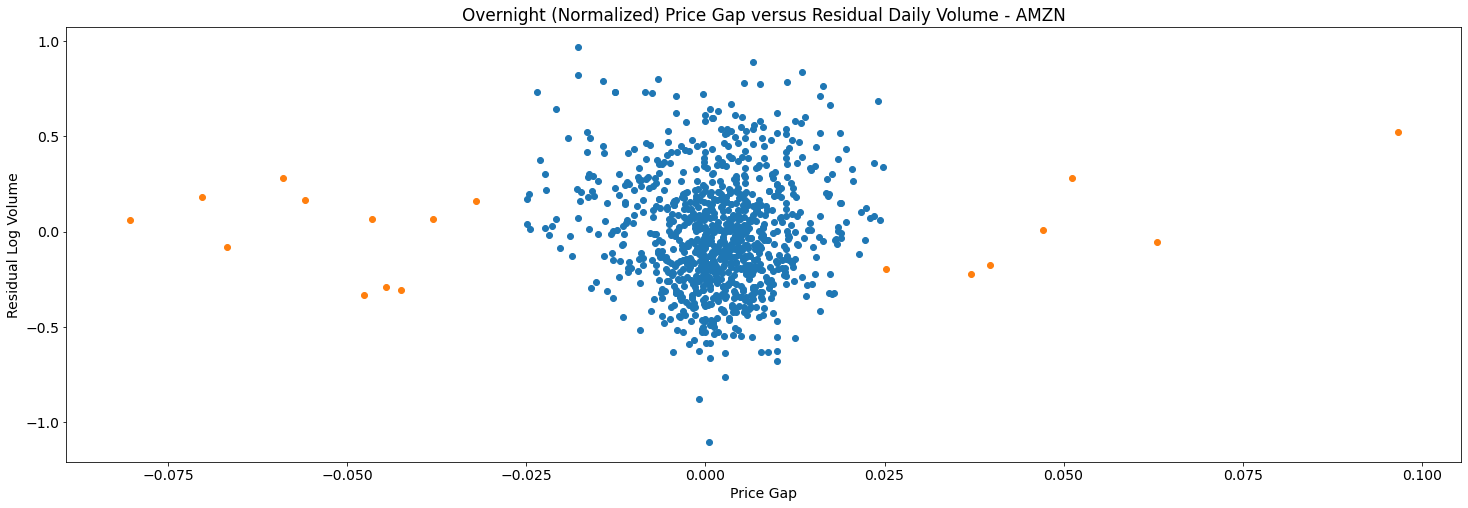

In [516]:
scatter_gap_normalized(df,'AMZN', 0.025)

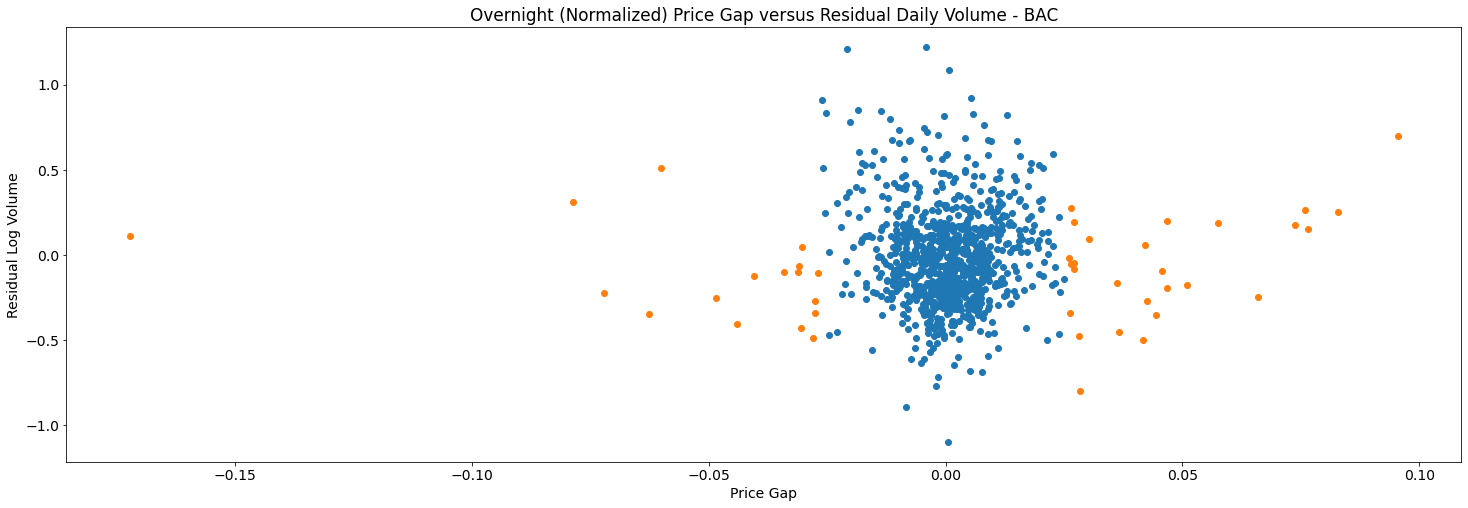

In [524]:
scatter_gap_normalized(df,'BAC', 0.026)

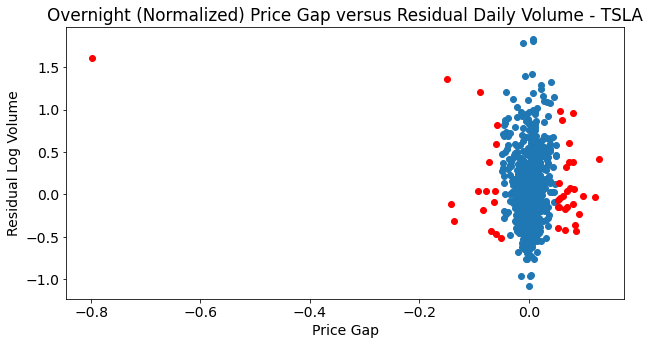

In [540]:
scatter_gap_normalized(df,'TSLA', 0.05)

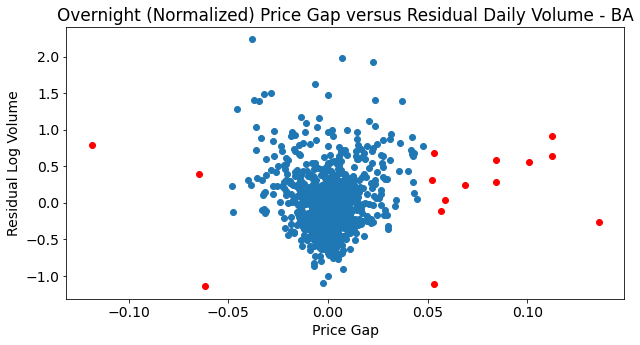

In [541]:
scatter_gap_normalized(df,'BA', 0.05)

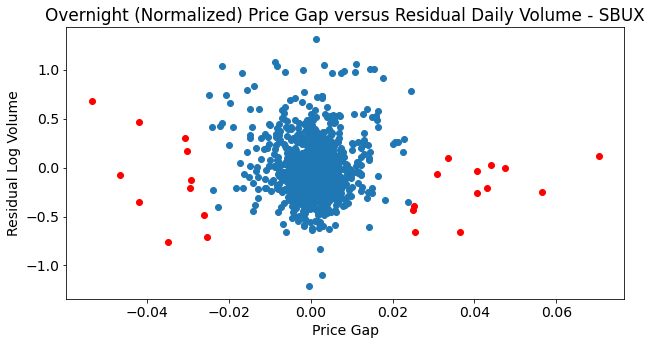

In [542]:
scatter_gap_normalized(df,'SBUX', 0.025)